In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#path = '/content/gdrive/My Drive/Colab Notebooks/707/Labs/'
#import sys
#sys.path.append(path)

In [2]:
# !pip install torch
# !pip install -U "ray[rllib]" torch

In [1]:
from dungeon.dungeon import Dungeon, index_to_actions

## Step 1 - Make a Wrapper to use Dungeon with RLLib.

Use the following guides:

Environment wrapper:
https://github.com/ray-project/ray/blob/81dcf9ff351d62da9c7e0493213c01765c9a2534/rllib/examples/custom_env.py#L77

Gym spaces:
https://gym.openai.com/docs/




In [2]:
import gym
import random, math
import numpy as np

from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from gym.spaces import Discrete, Box

class DungeonEnv(gym.Env):
    """Class that wrapps the Dungeon Environment to make it 
    compatible with RLLib."""

    def __init__(self, config: EnvContext):

        dungeon_size = config.get("size_env")

        self.dungeon = Dungeon(N=dungeon_size)

        self.action_space = Discrete(4)
        self.observation_space = Box(-1.0, 1.0, shape=(27,), dtype=np.float32)
        

    def reset(self):
        obs_dungeon = self.dungeon.reset()
        obs = self.convert_observations(obs_dungeon)
        return obs

    def step(self, action):
        assert action in [0, 1, 2, 3]
        action_str = index_to_actions[action].name

        obs_dungeon, reward, done = self.dungeon.step(action_str)
        obs = self.convert_observations(obs_dungeon)

        return obs, reward, done, {}

    def seed(self, seed=None):
        random.seed(seed)

    def convert_observations(self, dungeon_obs):
        # We normalize and concatenate observations
        
        relative_coord = dungeon_obs['relative_coordinates']/self.dungeon.size
        surroundings = dungeon_obs['surroundings'] / 4
        
        obs = np.concatenate([relative_coord, surroundings.flatten()])

        return obs


## Use DQN and train your algorithm on the Dungeon environment.

You can take inspiration from:
https://docs.ray.io/en/latest/rllib/rllib-training.html#basic-python-api

Experiment with the different parameters of the configuration:
https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#deep-q-networks-dqn-rainbow-parametric-dqn





In [3]:
import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print

config = dqn.DEFAULT_CONFIG.copy()
config["framework"] = "torch"
config["dueling"] = False
config["double_q"] = False
config["env"] = DungeonEnv
config["env_config"] = { "size_env": 15}
config["model"] = { "fcnet_hiddens": [64, 64],
                    "fcnet_activation": "relu",
    }

trainer = dqn.DQNTrainer(config=config)

# Can optionally call trainer.restore(path) to load a checkpoint.

avg_rewards = []

for i in range(100):
    # Perform one iteration of training the policy with PPO
    result = trainer.train()
    #print(pretty_print(result))
    print(result['episode_reward_mean'])
    avg_rewards.append(result['episode_reward_mean'])

    if i % 10 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)


Install gputil for GPU system monitoring.
2022-03-23 09:29:38,479	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


-262.7142857142857
checkpoint saved at C:\Users\sbrn692/ray_results\DQNTrainer_DungeonEnv_2022-03-23_09-29-37ztp_kuiu\checkpoint_000001\checkpoint-1
-267.8333333333333
-186.3
-179.2
-148.36363636363637
-117.02380952380952
-7.470588235294118
34.29347826086956
46.27
73.5
95.28
checkpoint saved at C:\Users\sbrn692/ray_results\DQNTrainer_DungeonEnv_2022-03-23_09-29-37ztp_kuiu\checkpoint_000011\checkpoint-11
123.17
165.84
187.85
191.06
189.38
180.14
158.6
143.97
127.08
103.51
checkpoint saved at C:\Users\sbrn692/ray_results\DQNTrainer_DungeonEnv_2022-03-23_09-29-37ztp_kuiu\checkpoint_000021\checkpoint-21
85.66
63.3
45.58
27.8
-0.01
-44.83
-62.63
-84.95
-102.65
-121.64
checkpoint saved at C:\Users\sbrn692/ray_results\DQNTrainer_DungeonEnv_2022-03-23_09-29-37ztp_kuiu\checkpoint_000031\checkpoint-31
-143.77
-161.53
-183.67
-201.89
-218.2
-215.63
-177.93
-105.84
5.71
199.39
checkpoint saved at C:\Users\sbrn692/ray_results\DQNTrainer_DungeonEnv_2022-03-23_09-29-37ztp_kuiu\checkpoint_000041\check

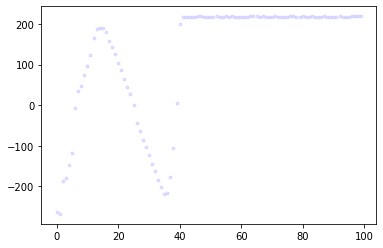

In [4]:
import matplotlib.pyplot as plt
plt.plot(avg_rewards, 'b.', alpha=.1)